# 导入相关库
# CNN + RNN 模型
# 使用Spectrogram

In [61]:
import pandas as pd
import os
import pathlib
import glob
import matplotlib. pyplot as plt
import numpy as np
import seaborn as sns
import librosa

import sklearn as sk 
import scipy
from sklearn import preprocessing
from sklearn import model_selection


## 构建数据集

In [91]:
data_dir = pathlib.Path('mini_speech_commands/')

fileset =[file for file in glob.glob(str(data_dir)+ "**/**/*.wav", recursive=True)]

In [92]:
len(fileset)

8000

In [93]:
dataset = pd.DataFrame(fileset, columns=['path'])

In [94]:
dataset['command']=dataset['path'].apply(lambda x:os. path.basename(os.path.dirname(x)))

In [95]:
dataset.head()

,path,command
0,mini_speech_commands\down\004ae714_nohash_0.wav,down
1,mini_speech_commands\down\00b01445_nohash_1.wav,down
2,mini_speech_commands\down\00f0204f_nohash_0.wav,down
3,mini_speech_commands\down\0132a06d_nohash_1.wav,down
4,mini_speech_commands\down\0132a06d_nohash_4.wav,down


In [96]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate /1e3)) # 窗口中采样点的个数
    noverlap = int(round(step_size * sample_rate /1e3))
    freqs, times, spec = scipy.signal.spectrogram(audio, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)

    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [97]:
#查看scipy, io读取的数据和librosa的区别
from scipy.io import wavfile
import scipy.io

sample_rate, signal= scipy.io.wavfile.read(dataset.loc[1,'path'])

print(signal)
print(sample_rate)
print(f"音频长度：{signal.shape}", signal.dtype)

s, sr = librosa.load(dataset.loc[1,'path'], sr=16000)

print(s)
print(sample_rate)
print (f"音频长度：{s.shape}", s.dtype)

[  53   55   40 ... -137 -152 -180]
16000
音频长度：(16000,) int16
[ 0.00161743  0.00167847  0.0012207  ... -0.00418091 -0.00463867
 -0.00549316]
16000
音频长度：(16000,) float32


In [98]:
def get_specgram(file_path):
    sample_rate, signal = scipy.io.wavfile.read(file_path)
    signal_padding = np.zeros((16000,))
    #统一输入音频文件长度，当音频文件大于1秒时切尾，当音频长度小于1秒时补零signal_padding np. zeros((16000,))
    if len(signal)>=16000:
        signal_padding = signal[:16000]
    else:
        signal_padding[:len(signal)] = signal
    
    #获取频谱
    _, _, specgram = log_specgram(signal_padding, sample_rate=sample_rate) 
    return specgram

In [99]:
file_path_check = dataset.loc[80,'path']

file_path_check

'mini_speech_commands\\down\\1942abd7_nohash_0.wav'

In [100]:
spec_check = get_specgram(file_path_check)

spec_check.shape ##(data, time) 适配RNN

(99, 161)

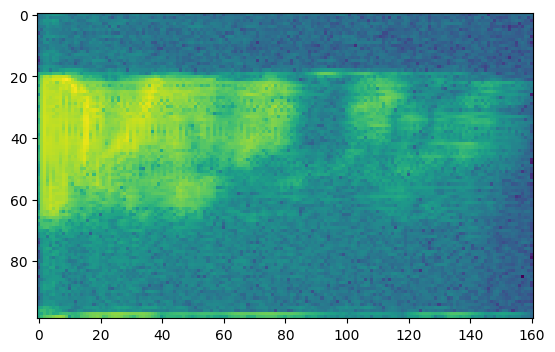

In [101]:
plt.imshow(spec_check)

In [102]:
dataset['spec'] = dataset['path'].apply(lambda x: get_specgram(x))

In [103]:
dataset.head()

,path,command,spec
0,mini_speech_commands\down\004ae714_nohash_0.wav,down,"[[6.1564674, 5.6721416, 1.4785006, 1.0322385, ..."
1,mini_speech_commands\down\00b01445_nohash_1.wav,down,"[[-8.119339, -7.100962, -2.9746146, -1.9071887..."
2,mini_speech_commands\down\00f0204f_nohash_0.wav,down,"[[3.2663877, 6.1833525, 5.1544065, 5.402227, 5..."
3,mini_speech_commands\down\0132a06d_nohash_1.wav,down,"[[-7.466669, -9.616711, -4.86994, -3.218716, -..."
4,mini_speech_commands\down\0132a06d_nohash_4.wav,down,"[[-5.385032, -4.7529283, -4.9070916, -4.096608..."


In [104]:
le = preprocessing.LabelEncoder()
dataset['cmd_value'] = le.fit_transform(dataset['command'])

In [105]:
dataset.tail()

,path,command,spec,cmd_value
7995,mini_speech_commands\yes\fe1916ba_nohash_1.wav,yes,"[[-10.874792, -5.53589, -3.86621, -4.4400816, ...",7
7996,mini_speech_commands\yes\fe5c4a7a_nohash_0.wav,yes,"[[7.4970326, 8.869189, 7.062622, 7.239739, 10....",7
7997,mini_speech_commands\yes\ff21fb59_nohash_0.wav,yes,"[[1.7132064, 5.4771934, 5.961012, 3.4359176, 1...",7
7998,mini_speech_commands\yes\ffd2ba2f_nohash_0.wav,yes,"[[0.16514386, 2.859499, 6.4408054, 7.1973853, ...",7
7999,mini_speech_commands\yes\ffd2ba2f_nohash_2.wav,yes,"[[-5.4296527, -3.146472, -1.6233718, -2.900053...",7


In [106]:
le.classes_

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype=object)

## 模型部分

In [107]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, LSTM
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [108]:
input_dim= (99, 161)
output_dim = len(le.classes_)
dropout =0.2

input_data = Input(shape=input_dim)

x=Conv1D(filters=256, kernel_size=10, strides=4)(input_data)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(dropout)(x)

x=LSTM(128, activation='relu', return_sequences=True, dropout=dropout)(x)
x=LSTM(128, activation='relu', return_sequences=False, dropout=dropout)(x)

x=Dense(units=64, activation='relu')(x)
x=Dropout(dropout)(x)

output_data = Dense(output_dim, activation='softmax')(x)

K.clear_session
model = Model(inputs=input_data, outputs=output_data)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 99, 161)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 23, 256)             │         412,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 23, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 23, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 750,920 (2.86 MB)

 Trainable params: 750,408 (2.86 MB)

 Non-trainable params: 512 (2.00 KB)

In [109]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard

sgd = SGD(learning_rate=0.00001, clipnorm=1.0)
adam = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [110]:
X = np.array([i for i in dataset['spec']])

In [111]:
X.shape

(8000, 99, 161)

In [112]:
y = np.array(dataset['cmd_value'])

In [113]:
y.shape

(8000,)

In [114]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42) # 8/2

In [115]:
EPOCHS = 50
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir='logs', histogram_freq=1, update_freq='epoch'),
        EarlyStopping(verbose=1, patience=5),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ],
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.1997 - loss: 2.0229
Epoch 1: val_accuracy improved from -inf to 0.25750, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.2002 - loss: 2.0220 - val_accuracy: 0.2575 - val_loss: 2.1028
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3511 - loss: 1.7567
Epoch 2: val_accuracy improved from 0.25750 to 0.40062, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.3514 - loss: 1.7559 - val_accuracy: 0.4006 - val_loss: 1.5776
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4255 - loss: 1.5749
Epoch 3: val_accuracy improved from 0.40062 to 0.53125, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.4257 - loss: 1.5745 - val_accuracy: 0.5312 - val_loss: 1.3031
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4823 - loss: 1.3966
Epoch 4: val_accuracy im

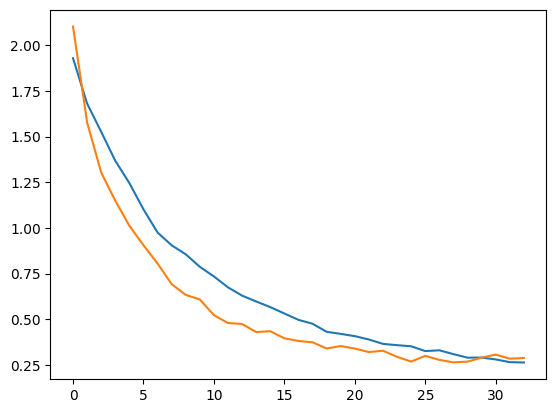

In [116]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.show()